In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, concatenate, Flatten, BatchNormalization, Lambda

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import PCA

# set random seeds
np.random.seed(42)
tf.random.set_seed(42)
tf.compat.v1.set_random_seed(42)
tf.experimental.numpy.random.seed(42)
print(tf.__version__)

2.15.0


Import data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/My Drive/CS567/final_project/finalMergedData.csv"
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocessing Data

In [ ]:
# Remove irrelevant columns in the dataset
remove_feature_list = ['gameId', 'playId', 'ballCarrierId', 'ballCarrierDisplayName', 'playDescription', 'passResult', 'playNullifiedByPenalty', 'homeTeamWinProbabilityAdded', 'visitorTeamWinProbilityAdded', 'foulName1', 'foulName2', 'foulNFLId1', 'foulNFLId2', 'frameId', 'collegeName',
                       'Full Name', 'Team', 'teamId']
df = df.drop(remove_feature_list, axis=1)

In [ ]:
df.columns[df.isna().any()]

Index(['yardlineSide', 'passLength', 'penaltyYards', 'offenseFormation',
       'defendersInTheBox', 'passProbability', 'expectedPointsAdded'],
      dtype='object')

In [ ]:
# Fill out empty entries
df['passLength'].fillna(0, inplace=True)
df['penaltyYards'].fillna(0, inplace=True)
df['defendersInTheBox'].fillna(0, inplace=True)
df['passProbability'].fillna(0, inplace=True)
df['expectedPointsAdded'].fillna(0, inplace=True)
df['yardlineSide'].fillna('N', inplace=True)
df['offenseFormation'].fillna('EMPTY', inplace=True)

# Convert special characters
def clock_to_min(time_str):
    hours, minutes = map(int, time_str.split(':'))
    return hours * 60 + minutes
df['gameClock'] = df['gameClock'].apply(clock_to_min)

def height_to_cm(height):
    feet, inches = height.split('-')
    return int(feet) * 30.48 + int(inches) * 2.54
df['height_x'] = df['height_x'].apply(height_to_cm)

### Normalize each numeric input feature with l2-norm


In [ ]:
# Initialize the Normalizer with L2 norm
normalizer = Normalizer(norm='l2')

# Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])
numeric_df = numeric_df.drop('playResult', axis=1)

# Apply normalization to all numerical input features and create a DataFrame from the normalized data
normalized_df = pd.DataFrame(normalizer.fit_transform(numeric_df), columns=numeric_df.columns)

# Concatenate non-numeric columns with normalized numeric columns
feature_df = pd.concat([normalized_df, df.select_dtypes(exclude=['number'])], axis=1)
df = pd.concat([feature_df, df['playResult']], axis=1)

### Transform textual features into numeric values

In [ ]:
# Store the number of categorical features used in training the model
num_cat_features = df.select_dtypes(exclude=['number']).shape[1]

# Create a label encoder object
label_encoder = LabelEncoder()

# Encode categorical parameters
unique_teams = pd.unique(df[['possessionTeam', 'defensiveTeam', 'yardlineSide']].values.ravel())
label_encoder.fit(unique_teams)
df['possessionTeam'] = label_encoder.transform(df['possessionTeam'])
df['defensiveTeam'] = label_encoder.transform(df['defensiveTeam'])
df['yardlineSide'] = label_encoder.transform(df['yardlineSide'])
df['offenseFormation'] = label_encoder.fit_transform(df['offenseFormation'])
df['playDirection'] = label_encoder.fit_transform(df['playDirection'])
df['Position'] = label_encoder.fit_transform(df['Position'])

### Plot the correlation matrix and the covariance matrix as heatmaps

expectedPoints                     -0.147904
defendersInTheBox                  -0.048534
offenseFormation                   -0.040583
gameClock                          -0.030466
distanceToEndZone                  -0.018656
playDirection                      -0.003481
yardlineSide                       -0.002207
y                                  -0.001141
x                                   0.001225
defensiveTeam                       0.001765
weight_x                            0.002265
possessionTeam                      0.003155
quarter                             0.005844
absoluteYardlineNumber              0.007430
preSnapHomeTeamWinProbability       0.008753
preSnapVisitorTeamWinProbability    0.011243
preSnapHomeScore                    0.013085
preSnapVisitorScore                 0.014105
overall_rating                      0.020333
age                                 0.022882
yearsPro                            0.023833
height_x                            0.034645
down      

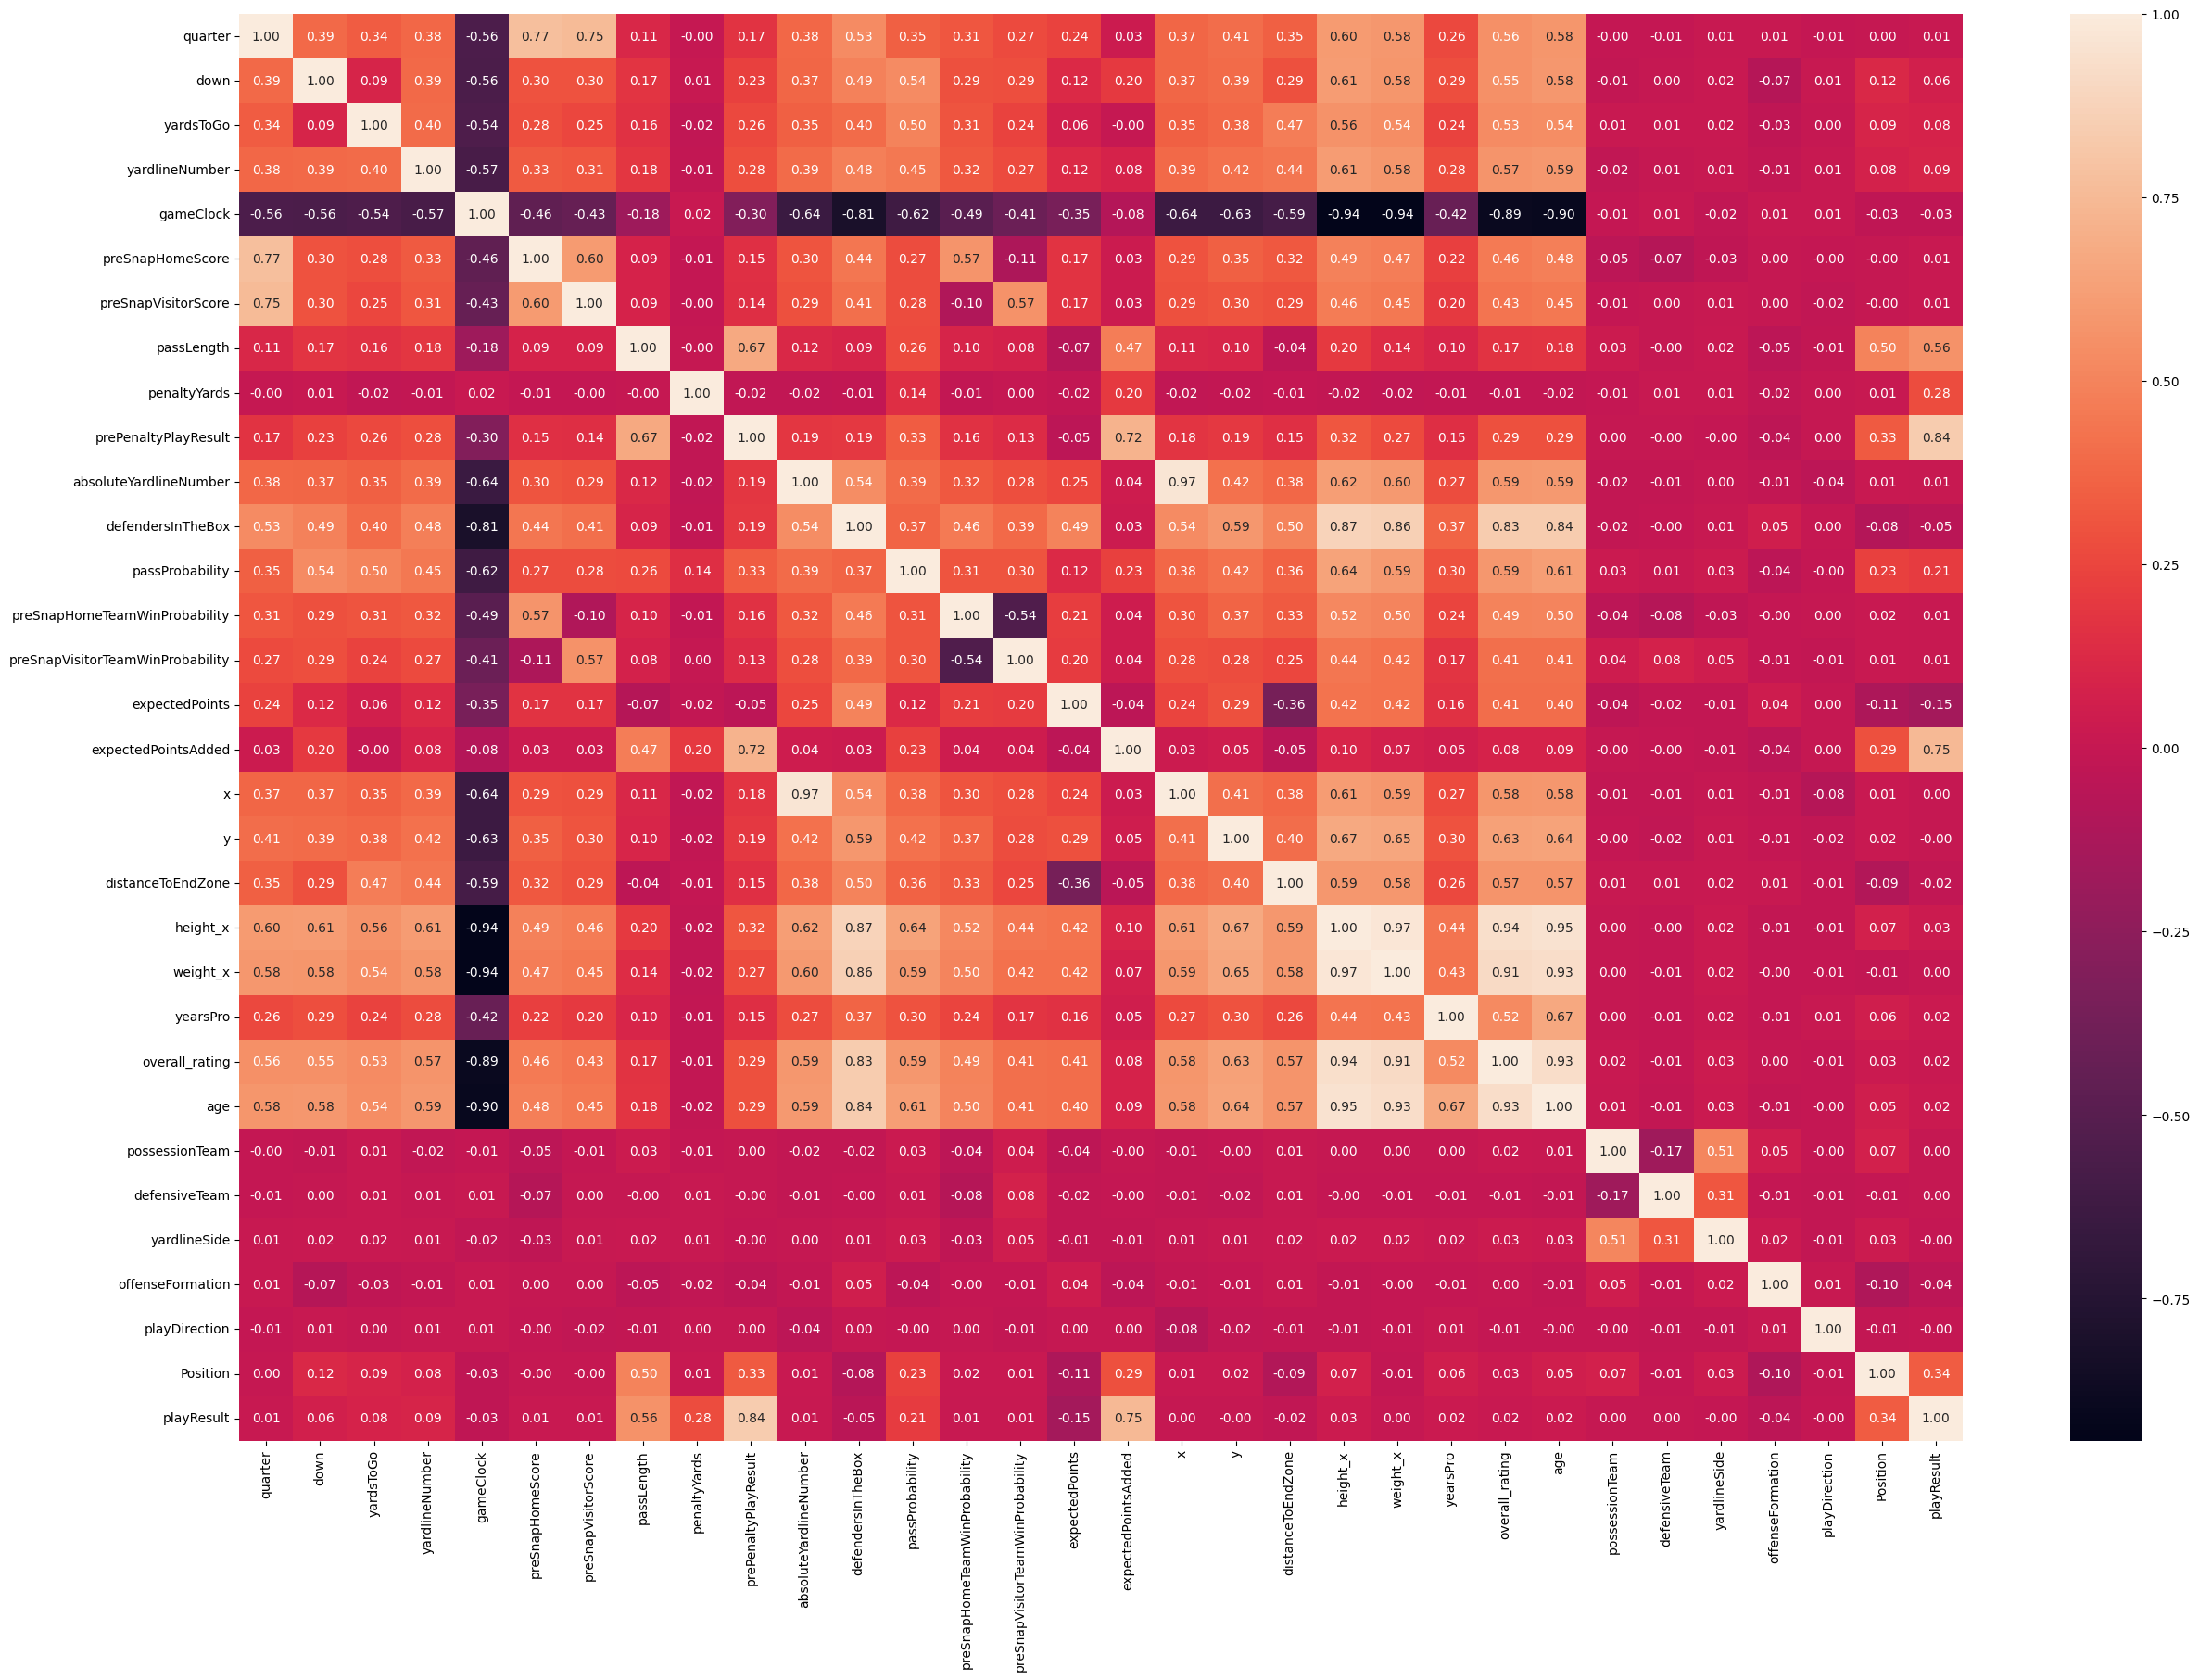

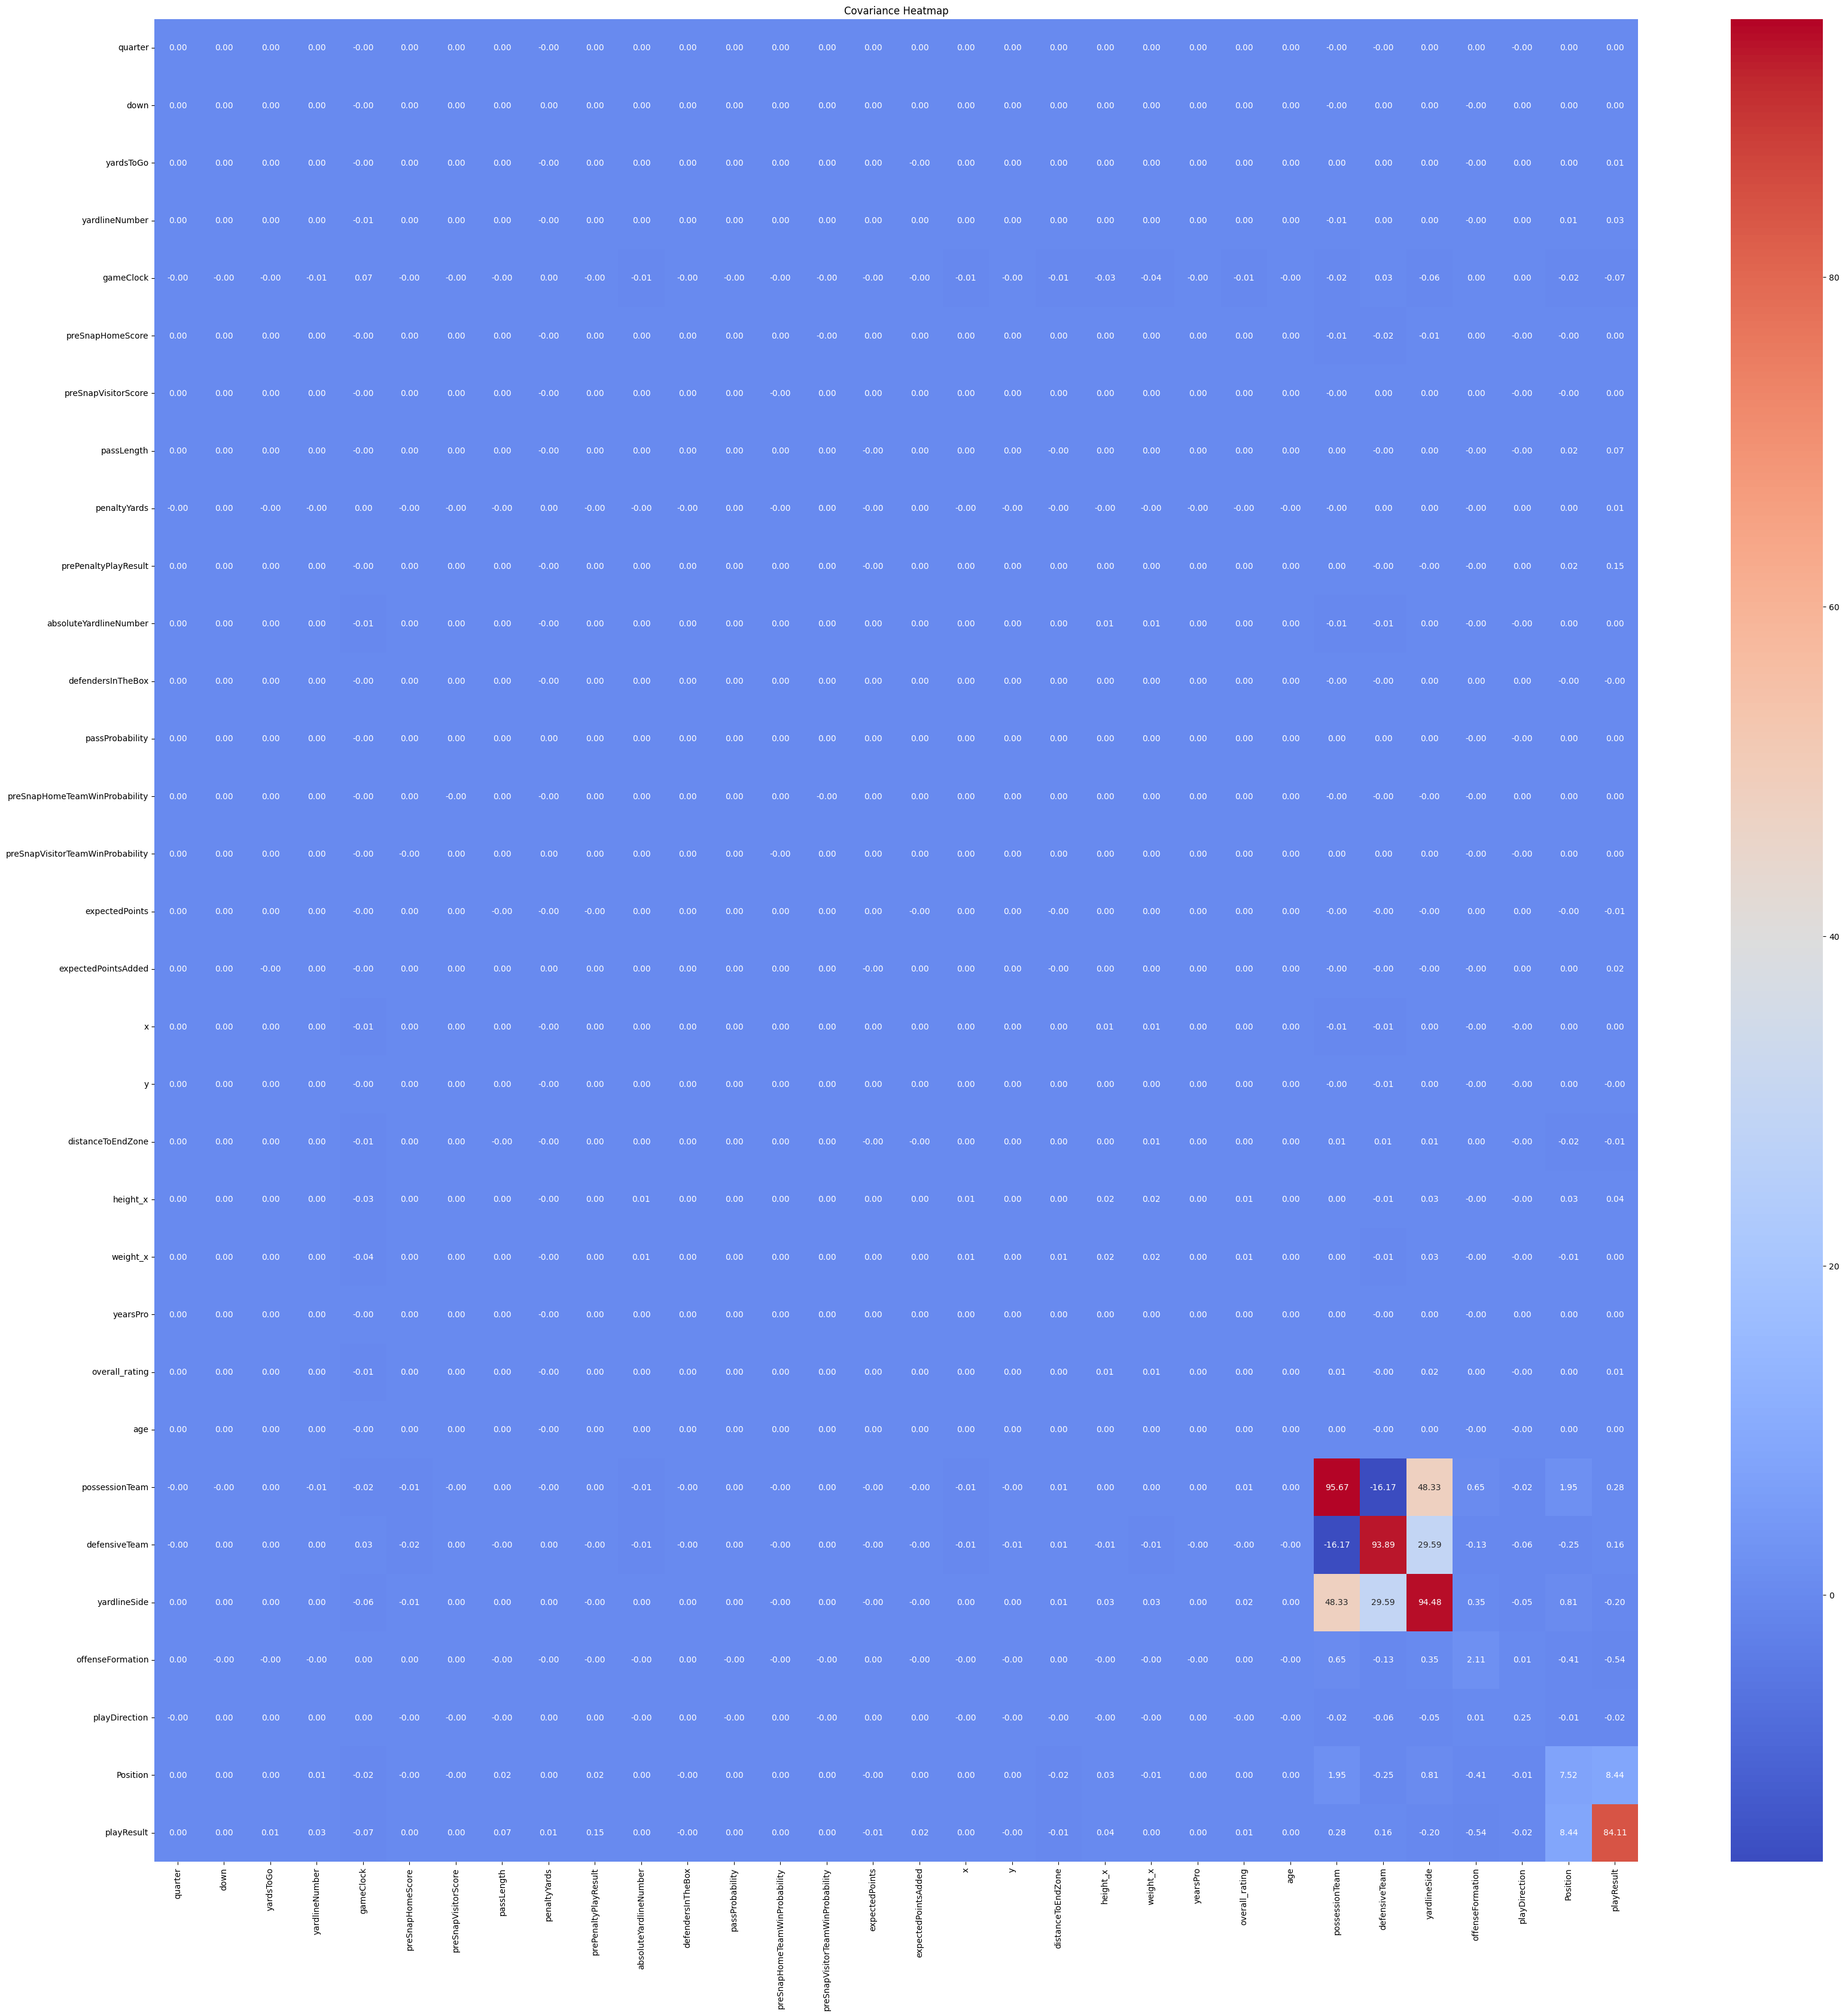

In [ ]:
# Calculate correlation matrix
correlation_matrix = df.corr()
# Plot correlation heatmap
print(correlation_matrix['playResult'].sort_values())
plt.figure(figsize=(30,20))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.show()

# Calculate covariance matrix
covariance_matrix = df.cov()
# Plot covariance heatmap
plt.figure(figsize=(40, 40))
sns.heatmap(covariance_matrix, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=df.columns, yticklabels=df.columns)
plt.title("Covariance Heatmap")
plt.show()

# Create corner plots
# sns.pairplot(df)
# plt.show()

### Split train/validation/test sets

Given the covariance heatmap and the correlation heatmap above, we can see strong dependency of the playResult on prePenaltyPlayResult, expectedPointsAdded, and passLength. We would use those three labels as the targets of our auxiliary task for each layer.

In [ ]:
# Columns removed from the input features
exclude_feature_list = ['playResult', 'prePenaltyPlayResult', 'expectedPointsAdded', 'passLength']
# Input parameters
X = df.drop(exclude_feature_list, axis=1)
# Parameters to be predicted
Y = df['playResult']
# Auxiliary targets
aux_target_list = ['prePenaltyPlayResult', 'expectedPointsAdded', 'passLength']
Y_aux = df[aux_target_list]

In [ ]:
# Training: X_train, Y_main_train, Y_aux_train
# Validation: X_val, Y_main_val, Y_aux_val
# Testing: X_test, Y_main_test, Y_aux_test
X_train, X_temp, Y_main_train, Y_main_temp, Y_aux_train, Y_aux_temp = train_test_split(X, Y, Y_aux, test_size=0.2, random_state=42)
X_val, X_test, Y_main_val, Y_main_test, Y_aux_val, Y_aux_test = train_test_split(X_temp, Y_main_temp, Y_aux_temp, test_size=0.5, random_state=42)

###PCA

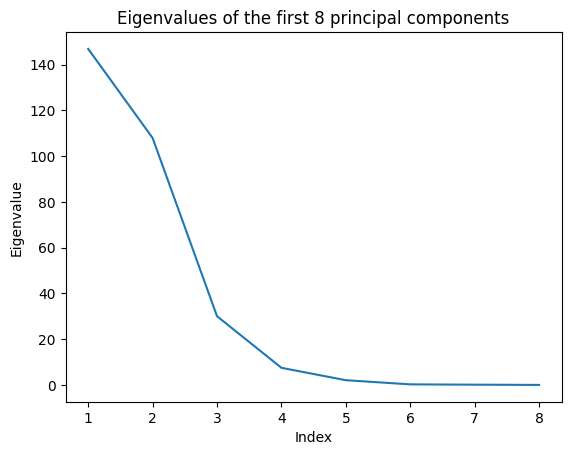

Percent of the variance explained by the first 8 principal components: 99.997219%


In [ ]:
# Create a PCA object
pca = PCA(n_components=8)  # Set the number of components you want to keep

# Fit PCA to the training data
pca.fit(X_train)

# Transform the training data to the new feature space
X_train_pca = pca.transform(X_train)

# Plot the eigenvalues of the principal components
D = pca.explained_variance_
n = np.shape(D)[0]
x = range(1, n+1)
fig, ax = plt.subplots()
ax.plot(x, D)
ax.set(xlabel = 'Index', ylabel = 'Eigenvalue')
ax.set_title('Eigenvalues of the first 8 principal components')
#fig.savefig("./ev_plot.png")
plt.show()
print("Percent of the variance explained by the first 8 principal components: %f%%" % (np.sum(pca.explained_variance_ratio_)*100))

# Get the principal components matrix
components = pca.components_
# Project X onto the principal components to reduce the dimensionality of the input collection of features
# X_train = np.dot(X_train, components.T)
# X_val = np.dot(X_val, components.T)
# X_test = np.dot(X_test, components.T)

# Neural Networks

## Build the model

In [ ]:
def create_model(num_features, num_cat_features, num_categories, cat_embd_dim, init_num_neurons, n_layers, dropout_rate, act_func, learn_rate):
  all_inputs = Input(shape=(num_features,))
  # define numeric input layers
  numeric_inputs = all_inputs[:, :(num_features - num_cat_features)]
  # define categorical input layers
  embedding_dim = cat_embd_dim  # Dimensionality of the embedding
  cat_embeddings = []
  for i, num_cat in enumerate(num_categories):
    embedding_layer = Embedding(input_dim=num_cat, output_dim=embedding_dim)(all_inputs[:, num_features - num_cat_features + i])
    flattened_embedding = Flatten()(embedding_layer)
    cat_embeddings.append(flattened_embedding)
  # Combine all embeddings and numerical inputs
  combined_inputs = concatenate([numeric_inputs] + cat_embeddings)

  # construct networks
  layer = BatchNormalization()(all_inputs)
  num_neurons = init_num_neurons
  for i in range(n_layers):
    # reduce the size of layers gradually
    if i != 0:
      num_neurons = init_num_neurons*0.5*i
    if num_neurons < 8:
      num_neurons = 8;
    layer = Dense(num_neurons, activation=act_func)(layer)
    layer = Dropout(dropout_rate)(layer)
    layer = BatchNormalization()(layer)
    # set up the auxiliary task
    if n_layers > 2 and i == n_layers//2:
      aux_output = Dense(3, activation='linear', name='aux_output')(layer)
    elif n_layers <= 2 and i == 1:
      aux_output = Dense(3, activation='linear', name='aux_output')(layer)
  main_output = Dense(1, activation='linear', name='main_output')(layer)

  # Combine main and auxiliary outputs into a single model
  combined_model = Model(inputs=all_inputs, outputs=[main_output, aux_output])

  # Compile the combined model
  losses = {'main_output': 'mean_squared_error', 'aux_output': 'mean_squared_error'}
  loss_weights = {'main_output': 1., 'aux_output': 0.5}
  metrics={'main_output': tf.keras.metrics.RootMeanSquaredError(), 'aux_output': tf.keras.metrics.RootMeanSquaredError()}
  combined_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learn_rate),
                  loss=losses,
                  loss_weights=loss_weights,
                  metrics=metrics)

  return combined_model

# Define the early-stopping module
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_main_output_loss",
        # "no longer improving" being defined as "for at least x epochs"
        patience=10,
        verbose=0,
        restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
    )
]

## Train the model with K-Fold cross validation

In [ ]:
cat_features_base = X_train.shape[1] - num_cat_features
num_categories = []
for i in range(num_cat_features):
  num_cat =  X_train.iloc[:, cat_features_base+i].nunique() + 1 # '+1' for zero-indexing of input layer dim
  num_categories.append(num_cat)

# bDefine hyperparameters grid
param_grid = {
    'batch_size': [32, 64],
    'cat_embd_dim': [8, 16],
    'init_num_neurons': [32, 64, 128],
    'n_layers': [3, 5],
    'dropout_rate': [0.2, 0.4],
    'act_func': ['log_softmax', 'relu', 'sigmoid'],
    'learning_rate': [0.0001, 0.001, 0.01]
}

# Generate all combinations of hyperparameters
param_combinations = list(ParameterGrid(param_grid))

# Print the total number of combinations
print("Total number of parameter combinations:", len(param_combinations))

# Define K-fold cross-validation
k_folds = 5
kf = KFold(n_splits=k_folds)

# Initialize lists to store evaluation results with different input parameters
parameter_labels = []
avg_val_loss = []

X_combined = np.concatenate((X_train, X_val), axis=0)
Y_main_combined = np.concatenate((Y_main_train, Y_main_val), axis=0)
Y_aux_combined = np.concatenate((Y_aux_train, Y_aux_val), axis=0)
for params in param_combinations:
  # Get one specific parameter combination
  act_func, batch_size, cat_embd_dim, dropout_rate, init_num_neurons, learning_rate, n_layers = params.values()
  val_loss_list_fold = []

  # Perform K-fold cross-validation
  for train_index, val_index in kf.split(X_combined):
    X_train_fold, X_val_fold = X_combined[train_index], X_combined[val_index]
    Y_main_train_fold, Y_main_val_fold = Y_main_combined[train_index], Y_main_combined[val_index]
    Y_aux_train_fold, Y_aux_val_fold = Y_aux_combined[train_index], Y_aux_combined[val_index]

    # Create and compile the model
    model = create_model(X_train.shape[1], num_cat_features, num_categories, cat_embd_dim,
                         init_num_neurons, n_layers, dropout_rate,
                         act_func, learning_rate)

    # train and evaluate the model with early-stopping
    history = model.fit(
        X_train_fold, [Y_main_train_fold, Y_aux_train_fold],
        validation_data=(X_val_fold, [Y_main_val_fold, Y_aux_val_fold]),
        batch_size=32, epochs=100,
        verbose=0,
        callbacks=callbacks
    )
    val_loss_list_fold.append(np.min(history.history['val_main_output_loss']))

  # Calculate average validation loss across folds
  avg_val_loss_fold = np.mean(val_loss_list_fold)
  avg_val_loss.append(avg_val_loss_fold)
  parameter_labels.append(f"Act: {act_func}, Batch_Size: {batch_size}, Cat_Emb_Dim: {cat_embd_dim}, Dropout: {dropout_rate}, N_Neurons: {init_num_neurons}, LR: {learning_rate}, N_Layers: {n_layers}")
  print(f"Avg. Validation Loss for params {params}: {avg_val_loss_fold}")

Total number of parameter combinations: 432
Avg. Validation Loss for params {'act_func': 'log_softmax', 'batch_size': 32, 'cat_embd_dim': 8, 'dropout_rate': 0.2, 'init_num_neurons': 32, 'learning_rate': 0.0001, 'n_layers': 3}: 67.17997436523437
Avg. Validation Loss for params {'act_func': 'log_softmax', 'batch_size': 32, 'cat_embd_dim': 8, 'dropout_rate': 0.2, 'init_num_neurons': 32, 'learning_rate': 0.0001, 'n_layers': 5}: 67.80188217163087
Avg. Validation Loss for params {'act_func': 'log_softmax', 'batch_size': 32, 'cat_embd_dim': 8, 'dropout_rate': 0.2, 'init_num_neurons': 32, 'learning_rate': 0.001, 'n_layers': 3}: 59.6960090637207
Avg. Validation Loss for params {'act_func': 'log_softmax', 'batch_size': 32, 'cat_embd_dim': 8, 'dropout_rate': 0.2, 'init_num_neurons': 32, 'learning_rate': 0.001, 'n_layers': 5}: 60.53682098388672
Avg. Validation Loss for params {'act_func': 'log_softmax', 'batch_size': 32, 'cat_embd_dim': 8, 'dropout_rate': 0.2, 'init_num_neurons': 32, 'learning_rat

## Plot the results

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(parameter_labels, avg_val_loss, marker='o', linestyle='-')
plt.xlabel('Parameter Combinations')
plt.ylabel('Average Validation Loss')
plt.title('Average Validation Loss Across Different Parameter Combinations')
plt.xticks(rotation=90, fontsize=8)  # Rotate and reduce font size of x-axis labels
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

In [ ]:
print(f'Best parameter combination: {parameter_labels[np.argmin(avg_val_loss)]}')

In [ ]:
# Create and train a new model with the best combination of params
model = create_model(
            X_train.shape[1],
            num_cat_features,
            num_categories,
            cat_embd_dim,
            init_num_neurons,
            n_layers,
            dropout_rate,
            act_func,
            learning_rate,
        )
history = model.fit(
            X_train, [Y_main_train, Y_aux_train],
            validation_data=(X_val, [Y_main_val, Y_aux_val]),
            epochs=100,
            batch_size=16,
            callbacks=callbacks
        )

In [ ]:
import matplotlib.pyplot as plt

training_losses = history.history['main_output_mean_squared_error']
validation_losses = history.history['val_main_output_mean_squared_error']

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss Per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(bottom=0)  # Sets the bottom of the y-axis to 0
plt.xlim(left=0, right=len(training_losses)-1)
plt.grid(True)  # Optionally add a grid for better readability
plt.show()

In [ ]:
predictions = model.predict(X_test)
main_output_predictions = predictions[0]
from sklearn.metrics import mean_absolute_error
mean_absolute_error(Y_main_test, main_output_predictions)